# Предстоит решить задачу сегментации медицинских снимков. 

In [5]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

In [19]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

In [5]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.io import imread
import matplotlib.pyplot as plt

from skimage.transform import resize
from IPython.display import clear_output
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [8]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [9]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [10]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

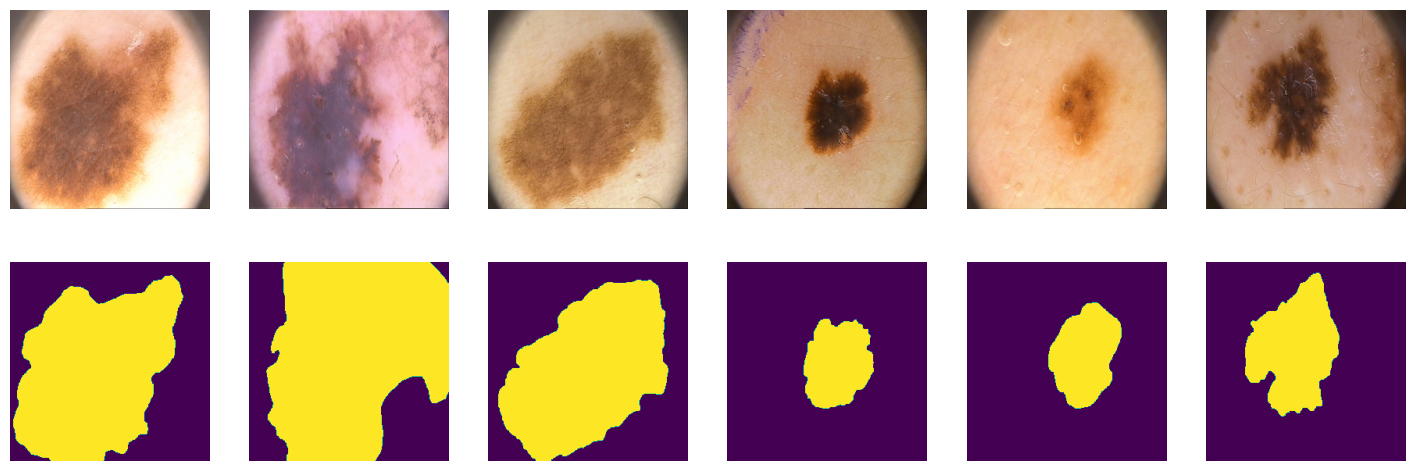

In [11]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [12]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [13]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [14]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

Функция для визуализации графиков Loss:

In [15]:
def show_losses(loss_train, loss_val):
    train_track = pd.DataFrame(
        data={'train':loss_train, 'valid': loss_val},
        index=range(1, len(loss_train) + 1)
    )
    sns.lineplot(train_track)
    plt.title('Losses')
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.show()

# Реализация различных архитектур:

-----------------------------------------------------------------------------------------

# SegNet

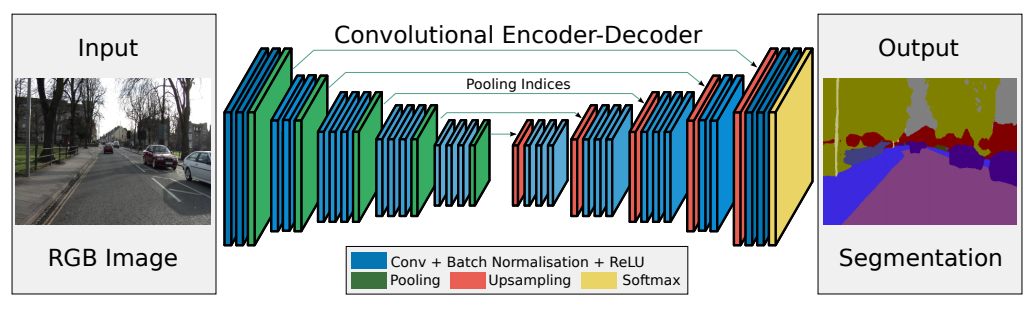

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [144]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

#         # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        e0, i0 = self.pool0(self.enc_conv0(x))      
        e1, i1 = self.pool1(self.enc_conv1(e0))     
        e2, i2 = self.pool2(self.enc_conv2(e1))     
        e3, i3 = self.pool3(self.enc_conv3(e2))     
        bottle_neck = self.bottleneck_conv(e3)
        d0 = self.dec_conv0(self.upsample0(bottle_neck, i3))
        d1 = self.dec_conv1(self.upsample1(d0, i2))
        d2 = self.dec_conv2(self.upsample2(d1, i1))
        d3 = self.dec_conv3(self.upsample3(d2, i0))
        return d3        

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [17]:
def bce_loss(y_real, y_pred):
    loss = y_pred - y_real*y_pred + (1 + torch.exp(-y_pred)).log()
    return loss.mean()

## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    torch.cuda.empty_cache()
   
    loss_train = []
    loss_val = []
    
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time.time()

        avg_loss_train = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss_train += loss / len(data_tr)
        loss_train.append(avg_loss_train.cpu().detach().item())
        toc = time.time()

        avg_loss_val = 0
        model.eval()  # testing mode
        for X_val, Y_val in data_val:
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).cpu().detach() # detach and put into cpu
                loss = loss_fn(Y_hat, Y_val)
                avg_loss_val += loss / len(data_val)
        loss_val.append(avg_loss_val.item())        

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Picture')
            plt.axis('off')
            
            plt.subplot(3, 6, k+7)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(
            f'Epoch: {epoch+1} / {epochs},\
            train loss:{round(float(avg_loss_train), 2)},\
            val loss:{round(float(avg_loss_val), 2)}'
        )
        plt.show()
        
    return loss_train, loss_val

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def predict(model, data, threshold=0.5):
    model.eval()  # testing mode
    with torch.no_grad():
        pred = torch.sigmoid(model(data.to(device)))
    return torch.where(pred > threshold, 1, 0)

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Обучение

In [ ]:
model = SegNet().to(device)

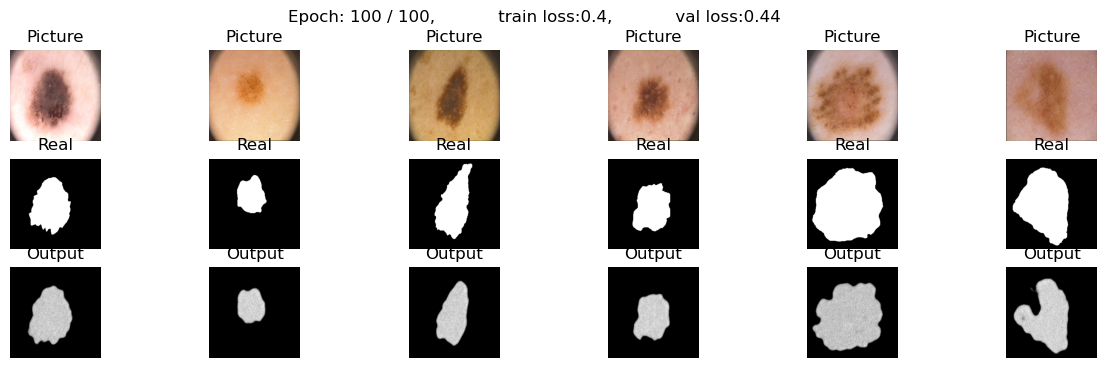

In [21]:
max_epochs = 100
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_train, loss_val = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

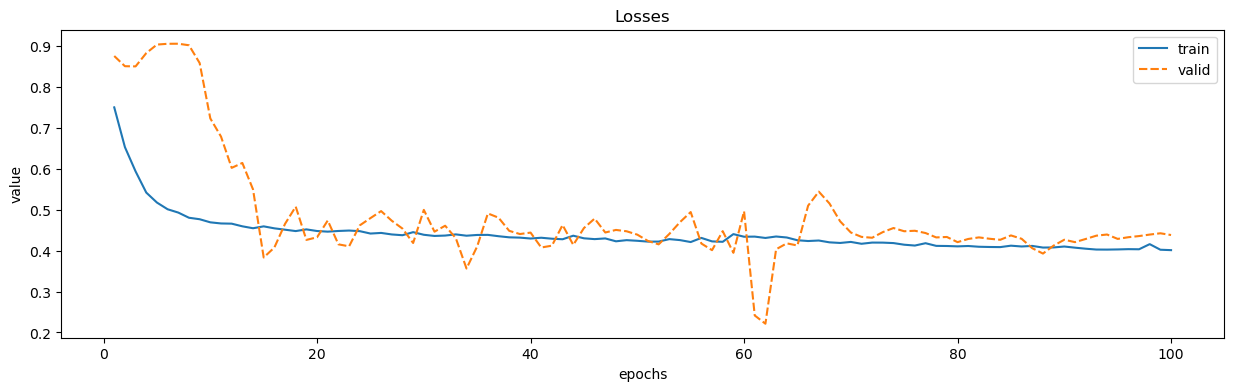

In [22]:
show_losses(loss_train, loss_val)

In [23]:
# train
score_model(model, iou_pytorch, data_tr)

0.9690000116825104

In [24]:
# validation
score_model(model, iou_pytorch, data_val)

0.7439999580383301

In [25]:
# test
score_model(model, iou_pytorch, data_ts)

0.7880000174045563

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

In [70]:
def dice_loss(y_real, y_pred, smooth = 1e-8):
    y_real = y_real.squeeze(1)    
    y_pred = y_pred.sigmoid().squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    num = torch.sum(y_real * y_pred)
    den = torch.sum(y_real + y_pred)
    res = 2. * num / (den + smooth)
    return 1. - torch.mean(res)

Проводим тестирование:

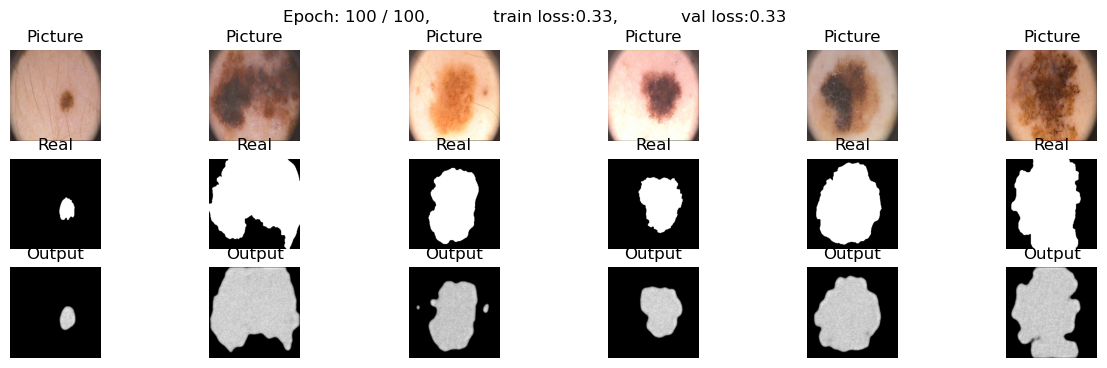

In [71]:
model_dice = SegNet().to(device)

max_epochs = 100
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
loss_train, loss_val = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

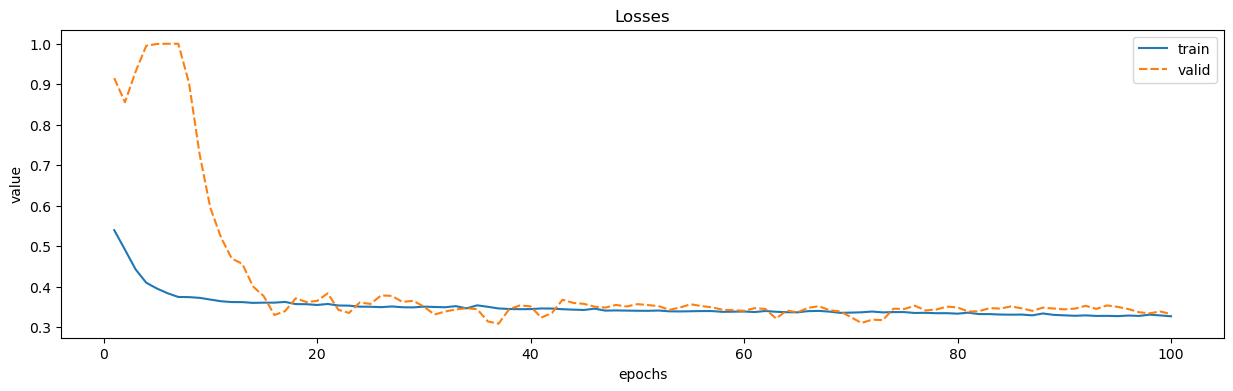

In [72]:
show_losses(loss_train, loss_val)

In [73]:
# train
score_model(model_dice, iou_pytorch, data_tr)

0.943000003695488

In [74]:
# validation
score_model(model_dice, iou_pytorch, data_val)

0.7720000147819519

In [75]:
# test
score_model(model_dice, iou_pytorch, data_ts)

0.7099999785423279

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [142]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(y_pred.sigmoid() + eps, 0, 1)
    your_loss = -(
        ((1 - y_pred) ** gamma) * y_real * y_pred.log() +
         (1 - y_real) * (1 - y_pred).log()
    ).mean()
    return your_loss


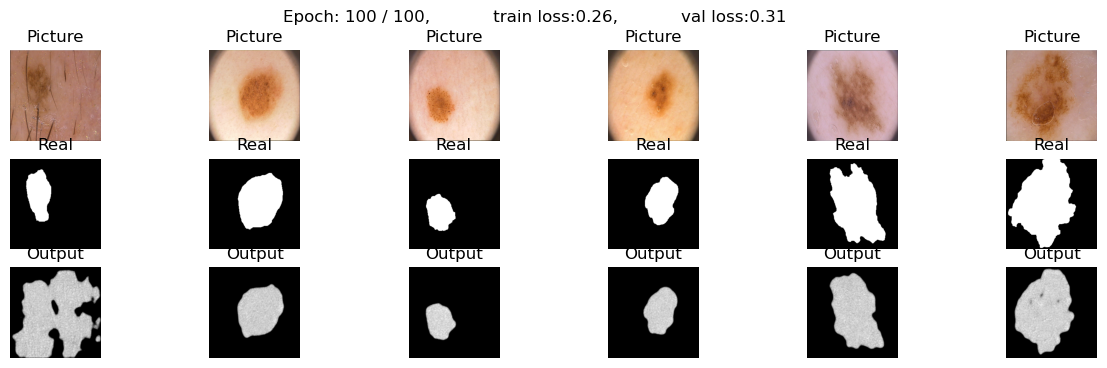

In [145]:
model_focal = SegNet().to(device)

max_epochs = 100
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
loss_train, loss_val = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

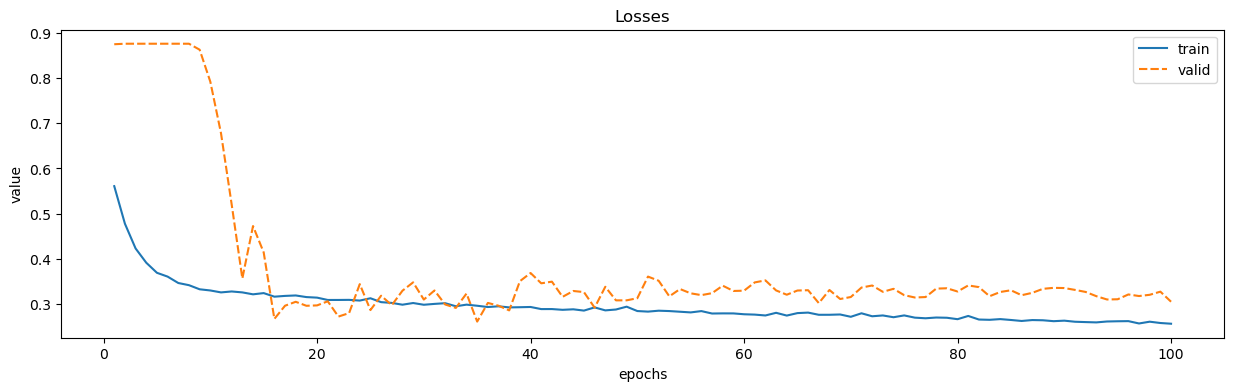

In [146]:
show_losses(loss_train, loss_val)

In [147]:
# train
score_model(model_focal, iou_pytorch, data_tr)

0.9360000044107437

In [148]:
# validation
score_model(model_focal, iou_pytorch, data_val)

0.7520000040531158

In [149]:
# test
score_model(model_focal, iou_pytorch, data_ts)

0.7360000014305115

3. Имплементируем функцию потерь **Jaccard/Intersection over Union (IoU) Loss:**

$$D(X,Y)=\frac{|X\cap Y|}{|X \cup Y|} = \frac{|X\cap Y|}{|X|+|Y| - |X\cap Y|}$$

Этот выбор обусловлен тем, она основывается на логике целевой метрики для оценки качества:

$$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$$

In [93]:
SMOOTH = 1e-8

class IoULoss:
    def forward(self, inputs, targets, smooth=SMOOTH):
        inputs = F.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        IoU = (intersection)/(union + smooth)
                
        return 1 - IoU
    
    def __call__(self, inputs, targets):
        return self.forward(inputs, targets)

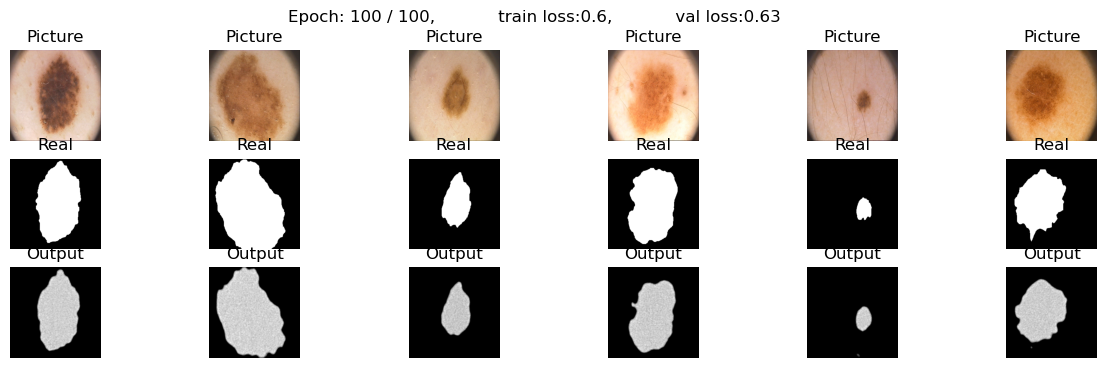

In [21]:
iou_loss = IoULoss()

model_iou = SegNet().to(device)

max_epochs = 100
optimaizer = torch.optim.Adam(model_iou.parameters(), lr=1e-4)
loss_train, loss_val = train(model_iou, optimaizer, iou_loss, max_epochs, data_tr, data_val)

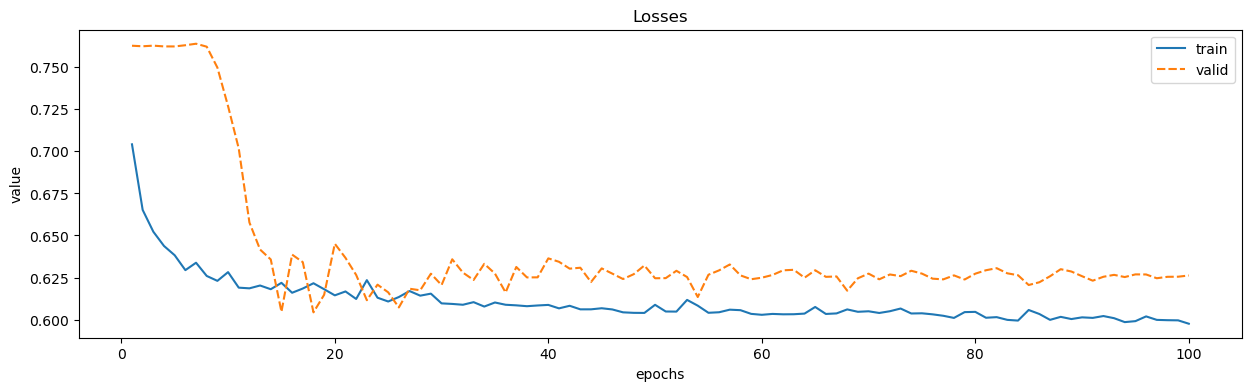

In [26]:
show_losses(loss_train, loss_val)

In [23]:
# train
score_model(model_iou, iou_pytorch, data_tr)

0.9949999749660492

In [24]:
# validation
score_model(model_iou, iou_pytorch, data_val)

0.7939999997615814

In [25]:
# test
score_model(model_iou, iou_pytorch, data_ts)

0.7439999878406525

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

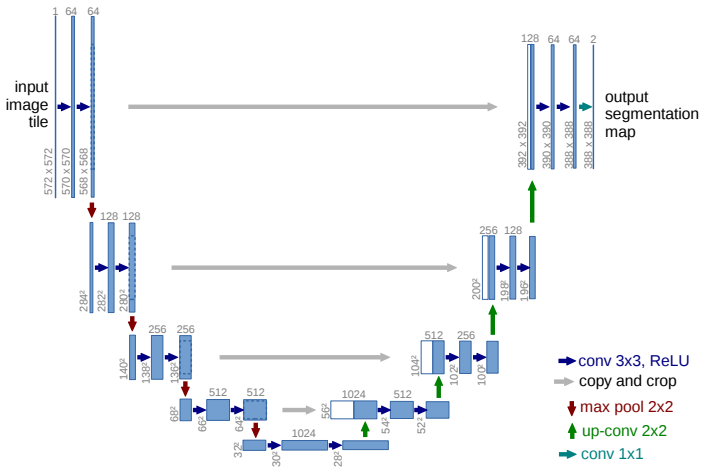

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [90]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            
        ) 
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            
        ) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
            
        ) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

#         # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

#         # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        p0 = self.enc_conv0(x)
        e0, i0 = self.pool0(p0)
        p1 = self.enc_conv1(e0)
        e1, i1 = self.pool1(p1)
        p2 = self.enc_conv2(e1)
        e2, i2 = self.pool2(p2)
        p3 = self.enc_conv3(e2)
        e3, i3 = self.pool3(p3)
        # bottleneck
        b = self.bottleneck_conv(e3)
        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b, i3), p3], axis=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0, i2), p2], axis=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1, i1), p1], axis=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2, i0), p0], axis=1))  # no activation
        return d3

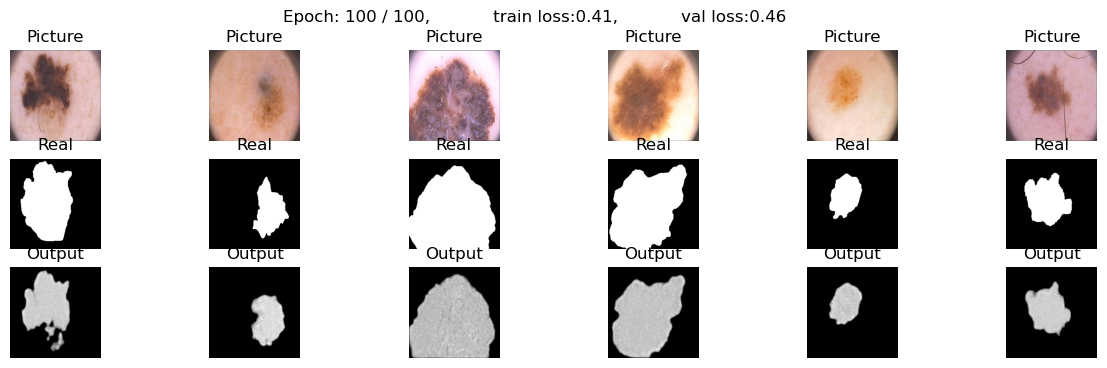

In [127]:
unet_model = UNet().to(device)
loss_train, loss_val = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=1e-4), bce_loss, 100, data_tr, data_val)

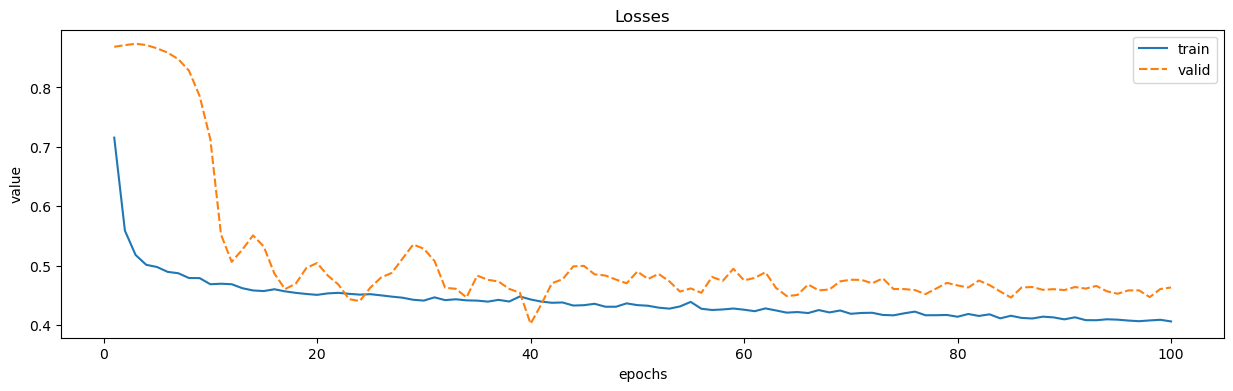

In [128]:
show_losses(loss_train, loss_val)

In [129]:
# train
score_model(unet_model, iou_pytorch, data_tr)

0.9680000096559525

In [130]:
# validation
score_model(unet_model, iou_pytorch, data_val)

0.7899999916553497

In [131]:
# test
score_model(unet_model, iou_pytorch, data_ts)

0.7720000147819519

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [132]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
            
        ) 
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            
        ) 
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) 
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
            
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1) # 32 -> 16

#         # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1) # MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        p0 = self.enc_conv0(x)
        i0 = p0.size()
        e0 = self.pool0(p0)
        
        p1 = self.enc_conv1(e0)
        i1 = p1.size()
        e1 = self.pool1(p1)
        
        p2 = self.enc_conv2(e1)
        i2 = p2.size()
        e2 = self.pool2(p2)
        
        p3 = self.enc_conv3(e2)
        i3 = p3.size()
        e3 = self.pool3(p3)
        
        # bottleneck
        b = self.bottleneck_conv(e3)
        
#         # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b, i3), p3], axis=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0, i2), p2], axis=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1, i1), p1], axis=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2, i0), p0], axis=1))  # no activation
        return d3

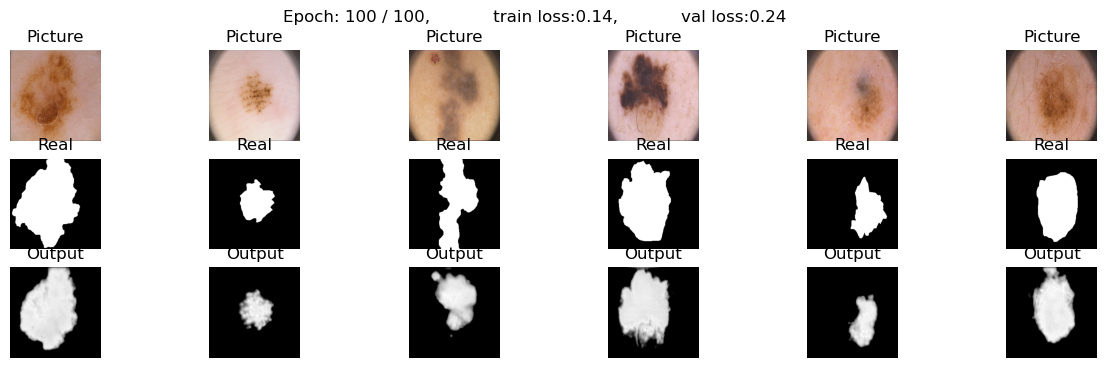

In [134]:
unet2_model = UNet2().to(device)
loss_train, loss_val = train(unet2_model, torch.optim.Adam(unet2_model.parameters()), bce_loss, 100, data_tr, data_val)

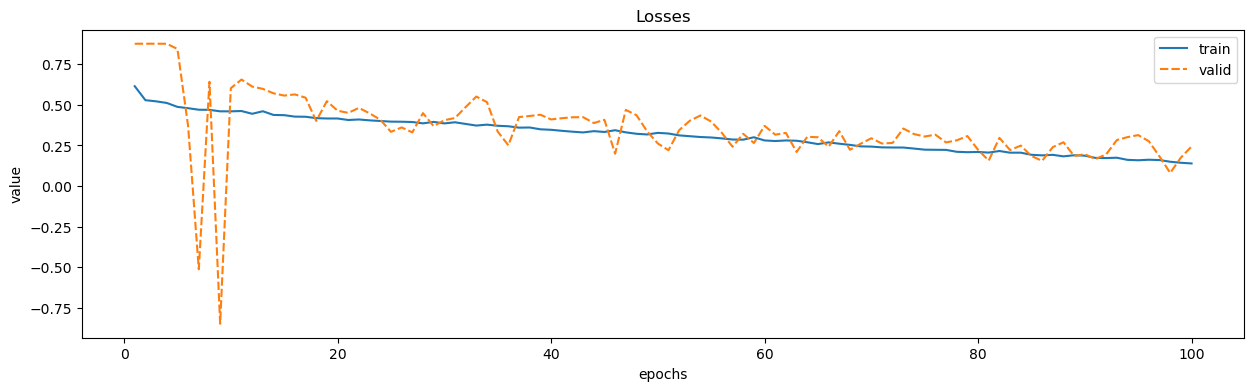

In [135]:
show_losses(loss_train, loss_val)

In [139]:
# train
score_model(unet2_model, iou_pytorch, data_tr)

0.734000027179718

In [140]:
# validation
score_model(unet2_model, iou_pytorch, data_val)

0.6860000193119049

In [141]:
# test
score_model(unet2_model, iou_pytorch, data_ts)

0.664000004529953

Сформируем таблицу, которая отражает значения целевых метрик целевой метрики на обучающей, проверочной и тестовой выборках для моделей, обученных с использованием бинарной кросс-энтропии (**BCE**):

| 	| SegNet | 	Unet	| UNet2 |
|---|---|---|---|
| Train | 	0.969 |	0.968 |	0.734 |
| Valid | 	0.744 |	0.790 |	0.686 |
| Test | 	0.788 |	0.772 |	0.664 |

Из таблицы видно, что результаты SegNet и Unet схожи, но учитывая, что последняя модель на валидационной выборке показала лучшее качество, что модель UNet моджно признать лучшей.

# Отчет: 


В ходе работы решалась задача сегментации медицинских снимков.
В качестве набора данных были использованы изображения, которые сопровождались размеченными масками к этим изображениям: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).
Всего в наборе 200 изображений, которые были разбиты на следующие части: $100/50/50$ - обучающая, проверочная(валидационная) и тестовая соответственно.
Исходные изображения были преведены к размеру $256\times256 $ пикселей.

В качестве функции потерь были рассмотрены следующие подходы:
* Binary Cross Entropy loss
* Dice Coefficient Loss
* Focal Loss
* IoULoss (Jaccard/Intersection over Union Loss)

Рассмотренные функции потерь представлены в тексте ноутбука в графическом виде с фиксацией их значений на обучающей и проверочной выборках при обучении моделей.
Функция **IoULoss** была предложена и имплементирована в работе, поскольку она основывается на логике целевой метрики.
Проведенные эксперименты показали, что функции потерь **BCE** и **IoULoss** дают схожие результаты на инференсе: 

| | 	BCE |	Dice |	Focal |	IoULoss |
|---|---|---|---|---|
| Train |	0.969 |	0.943 |	0.936 |	0.994 |
| Valid |	0.744 |	0.772 |	0.752 |	0.793 |
| Test |	0.788 |	0.709 |	0.736 |	0.743 |

Однако на тестовой выборке **BCE** показала лучшее качество, поэтому было принято решение использовать эту функцию потерь для построения других моделей.

Всего было рассмотрено 3 архитектуры нейронных сетей:
* SegNet
* Unet
* модернизированная версия Unet

Каждая из архитектур использована для построения моделей, каждая из которых обучалась на протяжении 100 эпох.
На некоторых графиках, отражающих значения функции потерь можно заметить, что для некоторых моделей такое количество эпох избыточно,
поскольку происходит переобучение. Однако для чистоты эксперимента число эпох не изменялось.
По результатам проведенных экспериментов была сформирована таблица, которая отражает значения целевой метрики на обучающей, проверочной и тестовой выборках для моделей,
обученных с использованием бинарной кросс-энтропии (**BCE**):

| 	| SegNet | 	Unet	| UNet2 |
|---|---|---|---|
| Train | 	0.969 |	0.968 |	0.734 |
| Valid | 	0.744 |	0.790 |	0.686 |
| Test | 	0.788 |	0.772 |	0.664 |

Из таблицы видно, что результаты SegNet и Unet схожи, но учитывая, что последняя модель на валидационной выборке показала лучшее качество, что модель UNet моджно признать лучшей.

**Вывод**.

В общем случае решалась задача бинарной классификации, поэтому бейзлайн для целевой метрики составляет $0.5$.
В ходе работы удалось на тестовой выборке добиться значения $0.77$, что признать модель адекватной.
Таким образом задача сегментации медицинских снимков успешно решена при заданных условиях и ограничениях.